## Setup

In [22]:
#Cleaning and Manipulation
import pandas as pd
import numpy as np

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Creating Pipelines
from imblearn.pipeline import Pipeline as ImPipeline

#Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

#Generating and Training Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Model Evaluation and Hyperparameter Tuning
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
import optuna

#SHAP Values (Feature Importance)
import shap

#Loading the dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

## Data Exploration

Firstly, we load the customer churn data. We have 7043 entries with 21 different variables, including customer information (ID, gender, dependents, etc.) as well as information about their subscription (whether they have TV streaming, online security, etc.) and billing (contract type, total and monthly charges, etc.). We also, most importantly, have a variable that tells us whether the customer has churned or not.

In [23]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The first thing to tackle is any missing values in the data.

In [24]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

An initial look suggests that there are no values to be concerned about. Now, we can handle some data type changes. Namely, we want to map the SeniorCitizen variable to Yes and No instead of 0 and 1 (at least for now), to make exploratory data analysis visualisations more intuitive. We also note that the TotalCharges variable is currently an object, and thus non-numeric. We change this as well.

In [25]:
df["SeniorCitizen"] = df["SeniorCitizen"].map({1: "Yes", 0: "No"})
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Now, when we check again for missing values, we see that 11 observations now don't have any information as to whether the customer is a senior citizen or not.

In [26]:
df[np.isnan(df["TotalCharges"])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


What we can also observe from these observations is that they all have 0 tenure, and haven't churned. This could suggest that these are new customers, who potentially haven't added all of their information. Given the small number of these cases, we decide to remove these observations from the data completely.

In [27]:
df.dropna(inplace = True)
df[np.isnan(df["TotalCharges"])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


We also check for any duplicated values in the data before we proceed.

In [28]:
df.duplicated().sum()

0

Finally, we split the data into independent (X) and dependent (y) variables. We also remove the customerID variable, since it's merely an identifier, and we don't want it to influence our results.

In [29]:
df.drop("customerID", axis = 1, inplace = True)

## EDA

In [30]:
#Splitting the df into train and test sets
train, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df["Churn"])

#Splitting the training set into training and validation sets
train, val = train_test_split(train, test_size = 0.2, random_state = 42, stratify = train["Churn"])

<Axes: xlabel='Churn', ylabel='percent'>

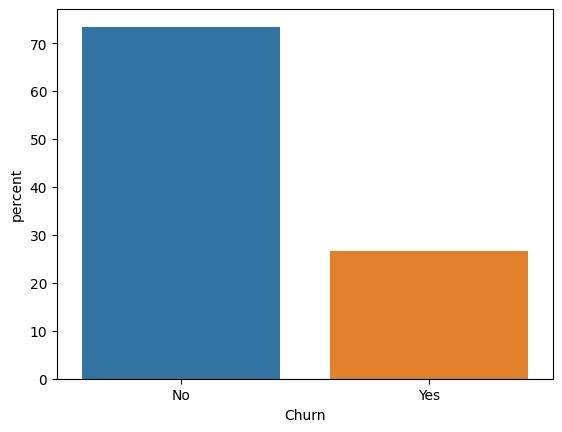

In [31]:
sns.countplot(x = "Churn", hue = "Churn", stat = "percent", data = train)

<Axes: xlabel='PaymentMethod', ylabel='percent'>

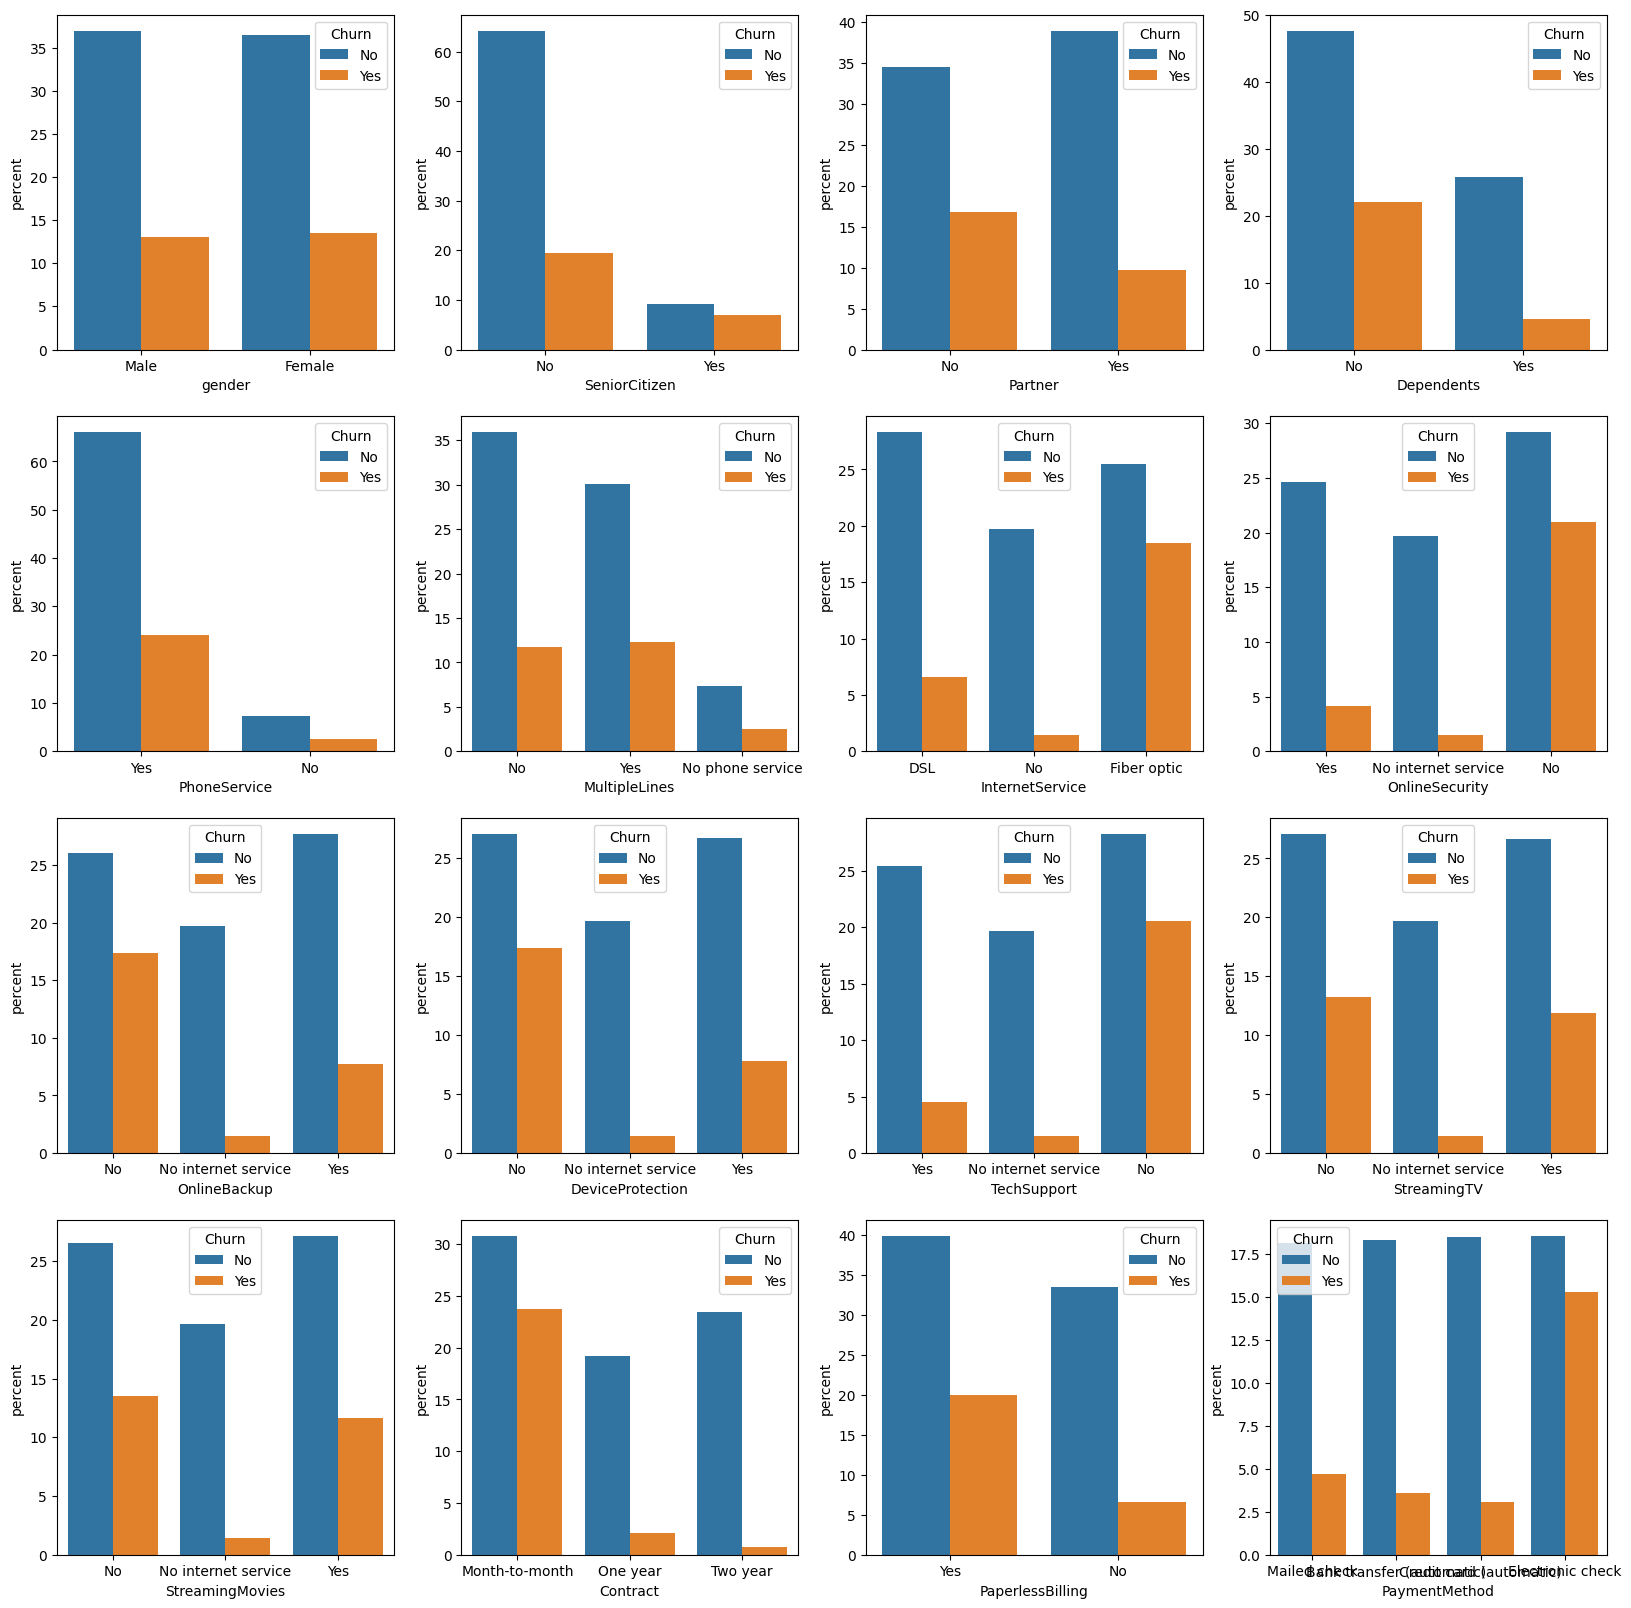

In [32]:
#Plotting countplots for categorical variables, grouped by Churn
fig, axes = plt.subplots(4, 4, figsize = (20, 20))
sns.countplot(x = "gender", stat = "percent", hue = "Churn", data = train, ax = axes[0, 0])
sns.countplot(x = "SeniorCitizen", stat = "percent", hue = "Churn", data = train, ax = axes[0, 1])
sns.countplot(x = "Partner", stat = "percent", hue = "Churn", data = train, ax = axes[0, 2])
sns.countplot(x = "Dependents", stat = "percent", hue = "Churn", data = train, ax = axes[0, 3])
sns.countplot(x = "PhoneService", stat = "percent", hue = "Churn", data = train, ax = axes[1, 0])
sns.countplot(x = "MultipleLines", stat = "percent", hue = "Churn", data = train, ax = axes[1, 1])
sns.countplot(x = "InternetService", stat = "percent", hue = "Churn", data = train, ax = axes[1, 2])
sns.countplot(x = "OnlineSecurity", stat = "percent", hue = "Churn", data = train, ax = axes[1, 3])
sns.countplot(x = "OnlineBackup", stat = "percent", hue = "Churn", data = train, ax = axes[2, 0])
sns.countplot(x = "DeviceProtection", stat = "percent", hue = "Churn", data = train, ax = axes[2, 1])
sns.countplot(x = "TechSupport", stat = "percent", hue = "Churn", data = train, ax = axes[2, 2])
sns.countplot(x = "StreamingTV", stat = "percent", hue = "Churn", data = train, ax = axes[2, 3])
sns.countplot(x = "StreamingMovies", stat = "percent", hue = "Churn", data = train, ax = axes[3, 0])
sns.countplot(x = "Contract", stat = "percent", hue = "Churn", data = train, ax = axes[3, 1])
sns.countplot(x = "PaperlessBilling", stat = "percent", hue = "Churn", data = train, ax = axes[3, 2])
sns.countplot(x = "PaymentMethod", stat = "percent", hue = "Churn", data = train, ax = axes[3, 3])
        

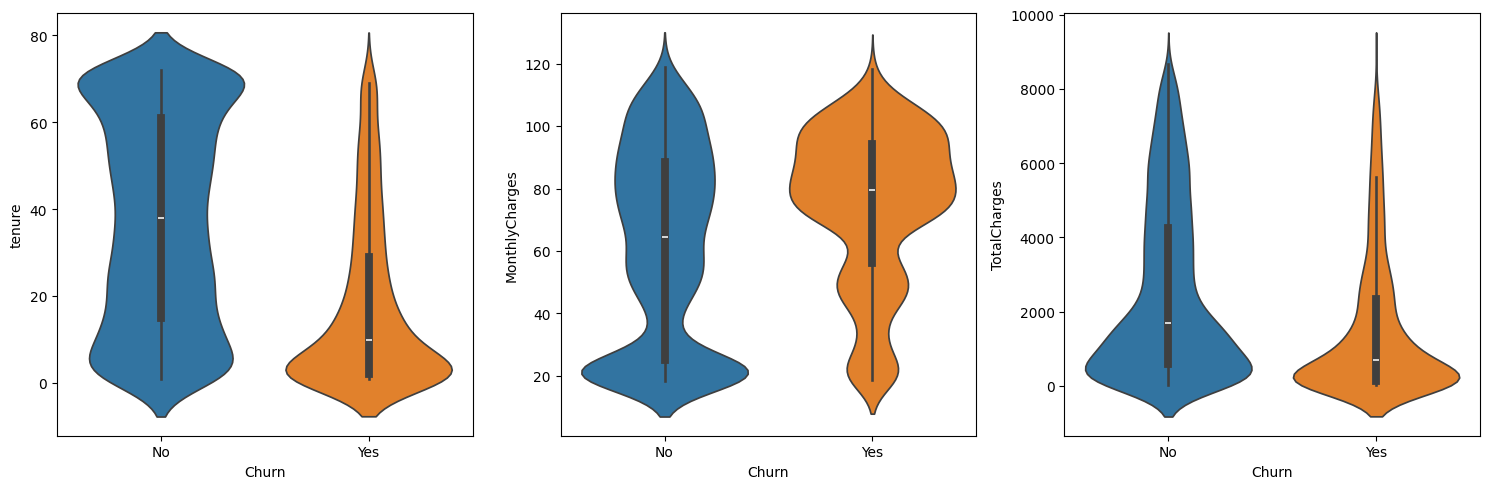

In [33]:
#Plotting violin plots for numerical variables by Churn
fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 5))
sns.violinplot(x = "Churn", y = "tenure", hue = "Churn", data = df, ax = axes[0])
sns.violinplot(x = "Churn", y = "MonthlyCharges", hue = "Churn", data = df, ax = axes[1])
sns.violinplot(x = "Churn", y = "TotalCharges", hue = "Churn", data = df, ax = axes[2])
plt.tight_layout()

## Feature Engineering

In [34]:
X_train = train.drop("Churn", axis = 1)
y_train = train["Churn"]

X_val = val.drop("Churn", axis = 1)
y_val = val["Churn"]    

In [35]:
cat_cols = X_train.select_dtypes(include = ["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude = ["object"]).columns.tolist()

## Building Models

#### Preprocessors and Resamplers

In [36]:
#One Hot Encoding categorical variables
cat = ImPipeline(steps = [
    ("encoder", OneHotEncoder(sparse_output = False, handle_unknown = "ignore"))
])

#MinMax scaling numerical variables
num = ImPipeline(steps = [
    ("scaler", MinMaxScaler())
])

#Combining categorical and numerical preprocessing pipelines
preprocessor = ColumnTransformer(transformers = [
    ("cat", cat, cat_cols),
    ("num", num, num_cols)
])

In [37]:
resampler = SMOTETomek(tomek = TomekLinks(sampling_strategy = "majority"), random_state=42)

In [38]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [39]:
model_names = ["Logistic", "K-NN", "Random Forest", "Gradient Boost", "XGBoost", "LightGBM"]
models = [LogisticRegression(random_state = 42), KNeighborsClassifier(), RandomForestClassifier(random_state = 42), GradientBoostingClassifier(random_state = 42),XGBClassifier(random_state = 42),  LGBMClassifier(is_unbalance = True, random_state = 42)]

f1 = []
balanced_accuracy = []
precision = []
recall = []
roc_auc = []

for i, name in enumerate(model_names):
    
    classifier = models[i]
    
    model = ImPipeline(steps = [
        ("preprocessor", preprocessor),
        ("resampler", resampler),
        ("classifier", classifier)
    ])
    
    model.fit(X_train, y_train)
    
    balanced_accuracy.append(balanced_accuracy_score(y_val, model.predict(X_val)))
    precision.append(precision_score(y_val, model.predict(X_val)))
    recall.append(recall_score(y_val, model.predict(X_val)))
    roc_auc.append(roc_auc_score(y_val, model.predict(X_val)))
    f1.append(f1_score(y_val, model.predict(X_val), average = "weighted"))

model_scores = pd.DataFrame(list(zip(model_names, f1, balanced_accuracy, precision, recall, roc_auc)), columns = ["Model", "F1 Score", "Balanced Accuracy", "Precision", "Recall", "ROC AUC"])
model_scores.sort_values("F1 Score", ascending = False)  

[LightGBM] [Info] Number of positive: 3304, number of negative: 3133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 6437, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513283 -> initscore=0.053143
[LightGBM] [Info] Start training from score 0.053143


d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,F1 Score,Balanced Accuracy,Precision,Recall,ROC AUC
3,Gradient Boost,0.783567,0.750974,0.565217,0.695652,0.750974
4,XGBoost,0.779801,0.724906,0.577287,0.612040,0.724906
5,LightGBM,0.776388,0.717756,0.574194,0.595318,0.717756
2,Random Forest,0.771763,0.714124,0.563291,0.595318,0.714124
0,Logistic,0.760262,0.756604,0.516704,0.775920,0.756604
1,K-NN,0.700066,0.707542,0.442718,0.762542,0.707542


## Model Tuning

In [40]:
def optimise_objective(trial):
    
    algorithm = trial.suggest_categorical("classifier", ["gbtree", "XGB", "LGBM"]) 
    
    if algorithm == "gbtree":
        gb_depth = trial.suggest_int("gb_max_depth", 2, 10)
        gb_eta = trial.suggest_float("gb_eta", 0.01, 0.99)
        gb_loss = trial.suggest_categorical("gb_loss", ["log_loss", "exponential"])
        gb_n_estimators = trial.suggest_int("gb_n_estimators", 10, 1000)
        
        model = GradientBoostingClassifier(max_depth = gb_depth, learning_rate=gb_eta, loss = gb_loss, n_estimators = gb_n_estimators, random_state = 42)
    
    elif algorithm == "XGB":
        xgb_depth = trial.suggest_int("xgb_max_depth", 2, 10)
        xgb_eta = trial.suggest_float("xgb_eta", 0.01, 0.99)
        xgb_booster = trial.suggest_categorical("xgb_booster", ["gbtree", "dart"])
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 10, 1000)
        
        model = XGBClassifier(max_depth = xgb_depth, learning_rate = xgb_eta, booster = xgb_booster, n_estimators = xgb_n_estimators, random_state = 42)
    
    else:
        lgbm_learning_rate = trial.suggest_float("lgbm_learning_rate", 0.01, 0.99)
        lgbm_boosting = trial.suggest_categorical("lgbm_boosting", ["gbdt", "dart"])
        lgbm_n_estimators = trial.suggest_int("lgbm_n_estimators", 10, 1000)
        lgbm_num_leaves = trial.suggest_int("lgbm_num_leaves", 10, 50)
        
        model = LGBMClassifier(learning_rate = lgbm_learning_rate, boosting_type = lgbm_boosting, n_estimators= lgbm_n_estimators, num_leaves = lgbm_num_leaves, is_unbalance = True, random_state = 42)
        
    pipeline = ImPipeline(steps = [
        ("preprocessor", preprocessor),
        ("resampler", resampler),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    score = f1_score(y_val, y_pred, average="weighted")
    
    return score

In [41]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed = 42))
study.optimize(optimise_objective, n_trials = 20)

[I 2025-06-22 13:57:49,315] A new study created in memory with name: no-name-58e5e6ad-a051-4a83-ab6c-823cb8e6d640
[I 2025-06-22 13:57:51,183] Trial 0 finished with value: 0.7579710675523414 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 7, 'xgb_eta': 0.1628982676335878, 'xgb_booster': 'gbtree', 'xgb_n_estimators': 868}. Best is trial 0 with value: 0.7579710675523414.
[I 2025-06-22 13:57:51,928] Trial 1 finished with value: 0.7498731753069521 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 10, 'xgb_eta': 0.8257937879844133, 'xgb_booster': 'gbtree', 'xgb_n_estimators': 191}. Best is trial 0 with value: 0.7579710675523414.
[I 2025-06-22 13:58:12,047] Trial 2 finished with value: 0.7544154249411347 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 4, 'xgb_eta': 0.6096158368279319, 'xgb_booster': 'dart', 'xgb_n_estimators': 373}. Best is trial 0 with value: 0.7579710675523414.
[I 2025-06-22 13:58:17,278] Trial 3 finished with value: 0.7616464847466533 and parameters: {'c

[LightGBM] [Info] Number of positive: 3304, number of negative: 3133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 6437, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513283 -> initscore=0.053143
[LightGBM] [Info] Start training from score 0.053143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-22 13:58:18,066] Trial 4 finished with value: 0.7535945544891429 and parameters: {'classifier': 'LGBM', 'lgbm_learning_rate': 0.8022294011541319, 'lgbm_boosting': 'gbdt', 'lgbm_n_estimators': 688, 'lgbm_num_leaves': 28}. Best is trial 3 with value: 0.7616464847466533.
[I 2025-06-22 13:58:19,873] Trial 5 finished with value: 0.7503696893336518 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 10, 'xgb_eta': 0.2636043819680166, 'xgb_booster': 'gbtree', 'xgb_n_estimators': 525}. Best is trial 3 with value: 0.7616464847466533.


[LightGBM] [Info] Number of positive: 3304, number of negative: 3133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2806
[LightGBM] [Info] Number of data points in the train set: 6437, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513283 -> initscore=0.053143
[LightGBM] [Info] Start training from score 0.053143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

d:\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-22 13:58:20,726] Trial 6 finished with value: 0.7540736354790305 and parameters: {'classifier': 'LGBM', 'lgbm_learning_rate': 0.7696301668938923, 'lgbm_boosting': 'gbdt', 'lgbm_n_estimators': 602, 'lgbm_num_leaves': 47}. Best is trial 3 with value: 0.7616464847466533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-22 13:58:40,938] Trial 7 finished with value: 0.766700965113885 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 4, 'xgb_eta': 0.3909037438956924, 'xgb_booster': 'dart', 'xgb_n_estimators': 363}. Best is trial 7 with value: 0.766700965113885.
[I 2025-06-22 13:58:41,943] Trial 8 finished with value: 0.7647130404515055 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 9, 'xgb_eta': 0.0830596308061754, 'xgb_booster': 'gbtree', 'xgb_n_estimators': 206}. Best is trial 7 with value: 0.766700965113885.
[I 2025-06-22 13:58:45,003] Trial 9 finished with value: 0.7551762175265926 and parameters: {'classifier': 'XGB', 'xgb_max_depth': 8, 'xgb_eta': 0.7658449397522268, 'xgb_booster': 'dart', 'xgb_n_estimators': 124}. Best is trial 7 with value: 0.766700965113885.
[I 2025-06-22 13:58:48,424] Trial 10 finished with value: 0.7640672273504273 and parameters: {'classifier': 'gbtree', 'gb_max_depth': 2, 'gb_eta': 0.7935248591769344, 'gb_loss': 'log_loss', 'gb_n_estimators': 338}. B

The best model is a Gradient Boosting classifier model with max depth 4, learning rate 0.301, 25 estimators, and exponential loss. This gives us a weighted f1-score of 0.783. Now, we train this final, tuned model.

In [42]:
final_model = ImPipeline(steps = [
    ("preprocessor", preprocessor),
    ("resampler", resampler),
    ("classifier", GradientBoostingClassifier(max_depth = 4, loss = "exponential", learning_rate = 0.3014992875253511, n_estimators = 25, random_state = 42))
])

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_val)
print("Final (GB) Model")
print("F1 Score:", f1_score(y_val, y_pred, average="weighted"))
print("Accuracy:", balanced_accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Final (GB) Model
F1 Score: 0.7831329530620628
Accuracy: 0.7393814733534705
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       826
           1       0.57      0.66      0.61       299

    accuracy                           0.78      1125
   macro avg       0.72      0.74      0.73      1125
weighted avg       0.79      0.78      0.78      1125



## Testing

In [43]:
X_test = test.drop("Churn", axis = 1)
y_test = le.fit_transform(test["Churn"])

In [44]:
print("Results:")
print("F1 Score:", f1_score(y_test, final_model.predict(X_test), average = "weighted"))
print("Accuracy:", balanced_accuracy_score(y_test, final_model.predict(X_test)))
print(classification_report(y_test, final_model.predict(X_test)))

Results:
F1 Score: 0.7783034713341429
Accuracy: 0.7498434029952736
              precision    recall  f1-score   support

           0       0.88      0.79      0.84      1033
           1       0.55      0.71      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.79      0.77      0.78      1407



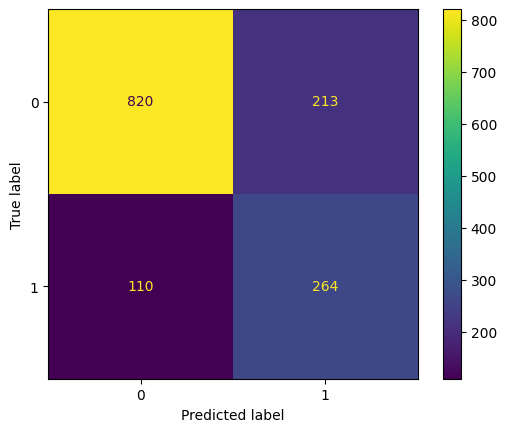

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.show()

In [46]:
final_model_model = final_model.named_steps["classifier"]
final_model_pp = final_model.named_steps["preprocessor"]
final_model_rs = final_model.named_steps["resampler"]

In [47]:
pp_X = final_model_pp.transform(X_test)
pp_y = le.fit_transform(y_test)

pp_cols = final_model_pp.get_feature_names_out().tolist()

explainer = shap.TreeExplainer(final_model_model)

shap_values = explainer.shap_values(pp_X)

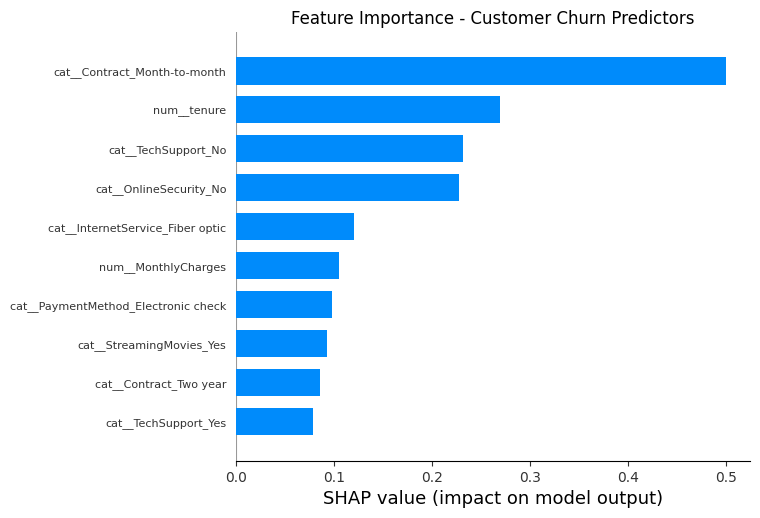

In [48]:
shap.summary_plot(shap_values, pp_X, feature_names = pp_cols, plot_type = "bar", max_display = 10, show = False)

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10, 5)
ax.tick_params(labelsize = 10)
ax.set_xlabel("SHAP value (impact on model output)")
plt.yticks(fontsize = 8)
ax.set_title("Feature Importance - Customer Churn Predictors")

plt.show()

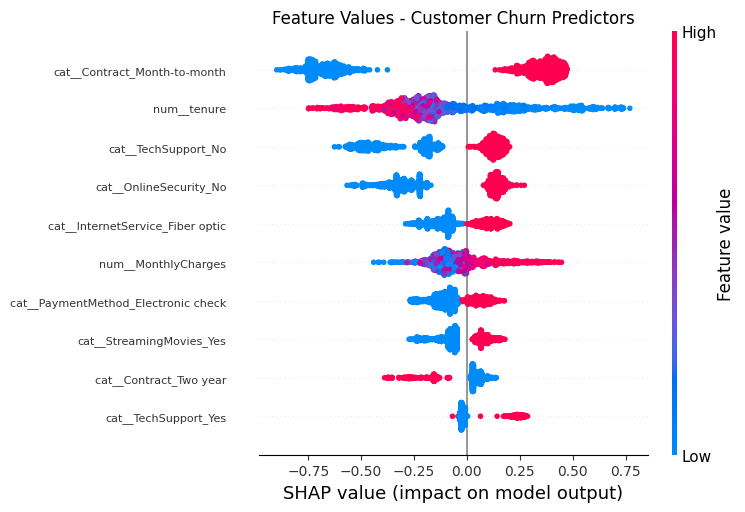

In [49]:

shap.summary_plot(shap_values, pp_X, feature_names = pp_cols, max_display = 10, show = False)

fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10, 5)
ax.tick_params(labelsize = 10)
ax.set_xlabel("SHAP value (impact on model output)")
plt.yticks(fontsize = 8)
ax.set_title("Feature Values - Customer Churn Predictors")

plt.show()